In [1]:
# modules required for handling dataframes
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sourcedir = '/home/yiheng/MinION_data/' # the directory where all the documents of each sequencing run are stored.
basedir = os.path.join(sourcedir, 'mock_com', 'illumina','amplicon')
genera_in_mock = ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
                  'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia', 
                  'Filobasidium','Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia', 
                  'Zygoascus', 'Purpureocillium', 'Cutaneotrichosporon', 'Naganishia']

In [3]:
def generate_final_df(sample):
    taxa_table = os.path.join(basedir, 'metadata_%s.tsv' % sample)
    frequency_table = os.path.join(basedir, 'feature-frequency-detail_%s.csv' % sample)
    taxa_df = pd.read_csv(taxa_table, header=1, sep='\t')
    taxa_df.columns = ['FeatureID', 'Taxon', 'Confidence']
    frequence_df = pd.read_csv(frequency_table, header=None, sep=',')
    frequence_df.columns = ['FeatureID', 'Frequency']
    final_df = pd.merge(taxa_df, frequence_df, how='outer', on='FeatureID')
    
    kingdom_list = []
    phylum_list = []
    class_list = []
    order_list = []
    family_list = []
    genus_list = []
    species_list = []
    for x in final_df.Taxon:
        try:
            kingdom_list.append(x.split(';')[0].split('__')[1])
        except IndexError:
            kingdom_list.append('Unclassified')
        try:
            phylum_list.append(x.split(';')[1].split('__')[1])
        except IndexError:
            phylum_list.append('Unclassified')
        try:
            class_list.append(x.split(';')[2].split('__')[1])
        except IndexError:
            class_list.append('Unclassified')
        try:
            order_list.append(x.split(';')[3].split('__')[1])
        except IndexError:
            order_list.append('Unclassified')
        try:
            family_list.append(x.split(';')[4].split('__')[1])
        except IndexError:
            family_list.append('Unclassified')
        try:
            genus_list.append(x.split(';')[5].split('__')[1])
        except IndexError:
            genus_list.append('Unclassified')
        try:
            species_list.append(x.split(';')[6].split('__')[1])
        except IndexError:
            species_list.append('Unclassified')
    final_df['kingdom'] = kingdom_list
    final_df['phylum'] = phylum_list
    final_df['class'] = class_list
    final_df['order'] = order_list
    final_df['family'] = family_list
    final_df['genus'] = genus_list
    final_df['species'] = species_list
    final_df = final_df.replace('unidentified', 'Unclassified')
    return final_df

In [4]:
def calculate_precision_rate(sample):
    tab_df = generate_final_df(sample)
    tab_df_in_mock = tab_df[tab_df.genus.isin(genera_in_mock)]
    precision_rate = sum(tab_df_in_mock.Frequency)/sum(tab_df.Frequency)
    return precision_rate   

In [5]:
def generate_precision_frequency_df(sample):
    precision_x_frequency = pd.DataFrame()
    precision_x_frequency['precision'] = [calculate_precision_rate('%s1' % sample), 
                                          calculate_precision_rate('%s2' % sample), 
                                          calculate_precision_rate('%s3' % sample)]
    precision_x_frequency['frequency'] = [generate_final_df('%s1' % sample).Frequency.sum(), 
                                          generate_final_df('%s2' % sample).Frequency.sum(),
                                          generate_final_df('%s3' % sample).Frequency.sum()]
    return precision_x_frequency

def generate_completeness_frequency_df(sample):
    completeness_x_frequency = pd.DataFrame()
    final_df_1 = generate_final_df('%s1' % sample)
    final_df_2 = generate_final_df('%s2' % sample)
    final_df_3 = generate_final_df('%s3' % sample)
    completeness_x_frequency['completeness'] = [len(final_df_1[final_df_1.genus.isin(genera_in_mock)].genus.unique())/24, 
                                                len(final_df_2[final_df_2.genus.isin(genera_in_mock)].genus.unique())/24, 
                                                len(final_df_3[final_df_3.genus.isin(genera_in_mock)].genus.unique())/24]
    completeness_x_frequency['frequency'] = [final_df_1.Frequency.sum(), 
                                             final_df_2.Frequency.sum(),
                                             final_df_3.Frequency.sum()]
    return completeness_x_frequency

In [6]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [7]:
IE_final_df = pd.concat([generate_final_df('IE1'), generate_final_df('IE2'), generate_final_df('IE3')], ignore_index=True)
MC_final_df = pd.concat([generate_final_df('MC1'), generate_final_df('MC2'), generate_final_df('MC3')], ignore_index=True)
# This W suppose to be the water control, and I didn't put it in the figure.
W_final_df = generate_final_df('W')

In [8]:
IE_completeness_df = generate_completeness_frequency_df('IE')
IE_completeness_df['completeness'] = round(IE_completeness_df['completeness']*1000000)
IE_completeness_df = IE_completeness_df.astype(int)
MC_completeness_df = generate_completeness_frequency_df('MC')
MC_completeness_df['completeness'] = round(MC_completeness_df['completeness']*1000000)
MC_completeness_df = MC_completeness_df.astype(int)

In [9]:
# Those numbers are copies from analyze_amplicon_minimap_kraken
IE_completeness_df_nanopore = pd.DataFrame()
IE_completeness_df_nanopore['completeness'] = [666666,666666,708333]
IE_completeness_df_nanopore['readnum'] = [14532,15799,17427]
MC_completeness_df_nanopore = pd.DataFrame()
MC_completeness_df_nanopore['completeness'] = [666666,625000,625000]
MC_completeness_df_nanopore['readnum'] = [10715,9535,7926]

In [10]:
# Calculate the average
IE_precision_mean = weighted_avg_and_std(generate_precision_frequency_df('IE').precision, generate_precision_frequency_df('IE').frequency)[0]
MC_precision_mean = weighted_avg_and_std(generate_precision_frequency_df('MC').precision, generate_precision_frequency_df('MC').frequency)[0]
IE_completeness_mean_illumina = weighted_avg_and_std(generate_completeness_frequency_df('IE').completeness, generate_completeness_frequency_df('IE').frequency)[0]*100
MC_completeness_mean_illumina = weighted_avg_and_std(generate_completeness_frequency_df('MC').completeness, generate_completeness_frequency_df('MC').frequency)[0]*100
IE_completeness_mean_nanopore = weighted_avg_and_std(IE_completeness_df_nanopore.completeness/1000000, IE_completeness_df_nanopore.readnum)[0]*100
MC_completeness_mean_nanopore = weighted_avg_and_std(MC_completeness_df_nanopore.completeness/1000000, MC_completeness_df_nanopore.readnum)[0]*100

# Calculate the standard deviation
IE_precision_std = weighted_avg_and_std(generate_precision_frequency_df('IE').precision, generate_precision_frequency_df('IE').frequency)[1]
MC_precision_std = weighted_avg_and_std(generate_precision_frequency_df('MC').precision, generate_precision_frequency_df('MC').frequency)[1]
IE_completeness_std_illumina = weighted_avg_and_std(generate_completeness_frequency_df('IE').completeness, generate_completeness_frequency_df('IE').frequency)[1]
MC_completeness_std_illumina = weighted_avg_and_std(generate_completeness_frequency_df('MC').completeness, generate_completeness_frequency_df('MC').frequency)[1]
IE_completeness_std_nanopore = weighted_avg_and_std(IE_completeness_df_nanopore.completeness/1000000, IE_completeness_df_nanopore.readnum)[1]
MC_completeness_std_nanopore = weighted_avg_and_std(MC_completeness_df_nanopore.completeness/1000000, MC_completeness_df_nanopore.readnum)[1]


In [11]:
# prepare data for completeness figure 3C
MC_completeness_df['Sequencing strategy'] = 'Ilumina'
MC_completeness_df_nanopore['Sequencing strategy'] = 'Nanopore'
MC_completeness_df_combined = pd.concat([MC_completeness_df, MC_completeness_df_nanopore], ignore_index=True)
MC_completeness_df_combined['Sample'] = 'Mixed culture'

IE_completeness_df['Sequencing strategy'] = 'Ilumina'
IE_completeness_df_nanopore['Sequencing strategy'] = 'Nanopore'
IE_completeness_df_combined = pd.concat([IE_completeness_df, IE_completeness_df_nanopore], ignore_index=True)
IE_completeness_df_combined['Sample'] = 'Pooled DNA'

In [12]:
completeness_df_combined = pd.concat([IE_completeness_df_combined, MC_completeness_df_combined], ignore_index=True)
completeness_df_combined['Completeness'] = completeness_df_combined['completeness']/10000

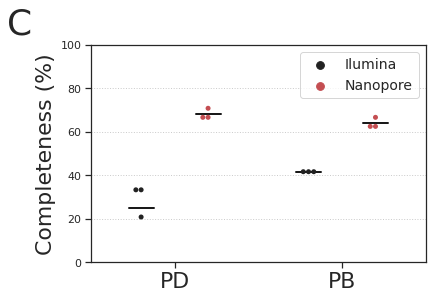

In [13]:
sns.set(style="ticks")
x_labels = ['PD', 'PB']

ax = sns.swarmplot(x="Sample", y="Completeness", hue='Sequencing strategy', edgecolor='1',
                   data=completeness_df_combined, color='r', dodge=True)
ax.set_xlabel('')
ax.yaxis.grid(linestyle='dotted')
handles, labels = ax.get_legend_handles_labels()
x_pos = np.arange(len(labels))
ax.legend(handles=handles[2:], labels=labels[2:], fontsize=14)
# This is to plot the weighted average lines for each sample
ax.plot([-0.275,-0.125], [IE_completeness_mean_illumina,IE_completeness_mean_illumina], lw=2, color='k')
ax.plot([0.125,0.275], [IE_completeness_mean_nanopore,IE_completeness_mean_nanopore], lw=2, color='k')
ax.plot([0.725,0.875], [MC_completeness_mean_illumina,MC_completeness_mean_illumina], lw=2, color='k')
ax.plot([1.124,1.275], [MC_completeness_mean_nanopore,MC_completeness_mean_nanopore], lw=2, color='k')
ax.yaxis.set_label_text('Completeness (%)', fontsize=22)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=22)
ax.text(-1, 105, 'C', fontweight=300, fontsize=36)
plt.ylim(0, 100)
plt.savefig(os.path.join(sourcedir, 'figures', 'Figure3C.png'), bbox_inches="tight", dpi=1000)

In [14]:
precision_IE = generate_precision_frequency_df('IE')
precision_IE['Sample'] = 'PD'
precision_MC = generate_precision_frequency_df('MC')
precision_MC['Sample'] = 'PB'
precision_df = pd.concat([precision_IE, precision_MC], ignore_index=True)
precision_df.precision = precision_df.precision*100

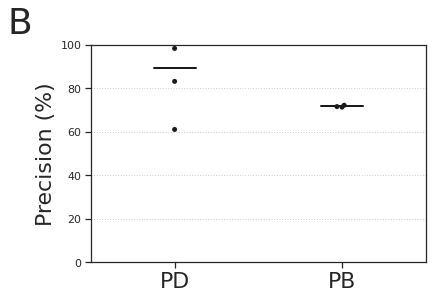

In [15]:
sns.set(style="ticks")
ax = sns.swarmplot(x="Sample", y="precision", edgecolor='1',
                   data=precision_df, color="k", dodge=True)
ax.set_xlabel('')
ax.yaxis.grid(linestyle='dotted')

# This is to plot the weighted average lines for each sample
ax.plot([-0.125,0.125], [IE_precision_mean*100,IE_precision_mean*100], lw=2, color='k')
ax.plot([0.875,1.125], [MC_precision_mean*100,MC_precision_mean*100], lw=2, color='k')

ax.yaxis.set_label_text('Precision (%)', fontsize=22)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=22)
ax.text(-1, 105, 'B', fontweight=300, fontsize=36)
plt.ylim(0, 100)
plt.savefig(os.path.join(sourcedir, 'figures', 'Figure3B.png'), bbox_inches="tight", dpi=1000)